# Moore's Law

In [67]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from collections import Counter
import matplotlib.pyplot as plt

We start with some light preprocessing, 

In [ ]:
benchmarks = pd.read_csv('./specdata20120207-1/benchmarks.csv', header = 0)

# Sanity check
#print([len(benchmarks[i]) for i in benchmarks.columns])

#Extracting Data from testID
benchmarks["date"] = benchmarks["testID"].str.extract(r'(\d{8})')
benchmarks["date"] = pd.to_datetime(benchmarks["date"], format="%Y/%m/%d")

benches = Counter(benchmarks.benchName)

#print([min(benchmarks[benchmarks.benchName == bench]) for bench in ])

To test Moore's predictions, we need timeseries data on speeds that both stretches over a large range, and is voluminous. So we look for the earliest hardware of the most popular benchmarks: 401.bzip2 seems to work well. 

We then use this benchmark to filter out the benchmarks dataset, and merge the summaries dataset over it according to the testID. 

In [309]:
summaries = pd.read_csv("./specdata20120207-1/summaries.csv")

#merging summaries and benchmarks
merged_data = pd.merge(data,summaries, on="testID", how = 'inner')
merged_data.hwAvail = pd.to_datetime(merged_data.hwAvail, format= "%b-%Y" )

most_common = lambda a: [i[0] for i in benches.most_common()[:a]]
#print([merged_data[merged_data.benchName == bench]["hwAvail"] for bench in most_common(10)])


#Selecting a benchmark
selected_benchmark = "401.bzip2"
#Filtering Data
data = benchmarks[benchmarks.benchName == selected_benchmark]

Moore's law makes the prediction that we will see a doubling in the number of transistors on commercial chips every two years. The benchmarks are a reasonable proxy for the number of transistors because we expect speed, as measured by the benchmarks, to be proportional to the number of transistors in the CPUs used.

To fit a linear model over what Moore posits as an exponential relationship, we log the benchmarked speed, represented as "base" in the dataframe. 

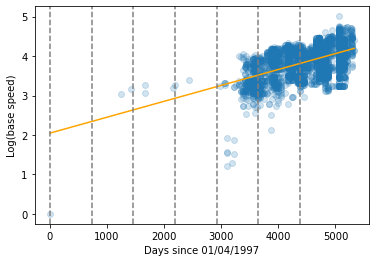

In [337]:
# Semi-log scale
y = np.log2(merged_data["base_x"]).values
x = merged_data.hwAvail.sort_values()

x_days = (x - x[0]).dt.days.values.reshape(-1,1)

reg = LinearRegression().fit(x_days,y)
y_pred = reg.predict(x_days)


plt.scatter(x_days,y, alpha= 0.2)
plt.plot(x_days,y_pred, color = "orange")
plt.ylabel("Log(base speed)")
plt.xlabel(f'Days since {min(x).strftime("%d/%m/%Y")}')

for i in range(7):
    plt.axvline(i*365*2, linestyle = "--", color = 'grey')

In [341]:
assert reg.score(x_days, y) == metrics.r2_score(y,y_pred)
print(f'R^2 is {reg.score(x_days, y)}')
print(f'Mean Squared Error is {metrics.mean_absolute_error(y,y_pred)}')
print(f'Mean Absolute Error is {metrics.mean_squared_error(y,y_pred)}')

R^2 is 0.2679074320263338
Mean Squared Error is 0.28676230005558256
Mean Absolute Error is 0.12360574771111629


For Moore's Law to hold, we need to see the prediction in log(base speed) increment by 1 every 2 years, marked using the series of grey lines. However, it seems to be happening at a slower rate, doubling a little less than every four years. This can be because of the high amount of clustering, and consequent variance, towards the later years, and a paucity of data in earlier years. Lots of left skew, which disfavors a linear model that prefers features distributed normalesque. 

These facts of poor fit are expressed in the fairly low R^2 of 0.26, with an MSE of 0.28 and an MAE of 0.12. The difference in the latter pair of errors evince the biasing power of earlier benchmarks on the MSE. 

# MNIST

In [223]:
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


Performing the requisite visualization tasks during the preprocessing stage, as we want to recast the pixel matrix from an [8 x 8] to [1 x 64] matrix before training. The KNN classifier will have 64 features - or better yet, dimensions - to compute neighbourly distances from. 

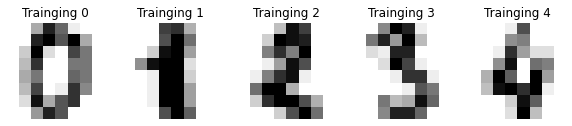

In [347]:
digits  = load_digits()

# Plotting examples
fig, axs = plt.subplots(nrows  = 1, ncols = 5, figsize = (10,10))

for ax, img, lab in zip(axs, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(img, cmap = plt.cm.gray_r, interpolation = 'nearest')
    ax.set_title(f'Trainging {lab}')

plt.show()

In [ ]:
# filter out 7s and 3s. Can be done more elegantly. 
targets = {i:e for i,e in enumerate(digits.target)}

filtered_targets = {}

for index,digit in targets.items():
    if digit == 7 or digit == 3:
        filtered_targets[index] = digit


target = list(filtered_targets.values())
filtered_images = np.array([digits.images[i] for i in target])

# flatten images
n_samples = len(filtered_images)
data = filtered_images.reshape((n_samples, -1))
assert len(data[0]) == 64

# hold out data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, shuffle=False)

In [346]:
#2 clusters -  one for each digit
model = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
preds = model.predict(X_test)

print(f'On a test set size of {len(y_test):}, our classifier has scored:',
      '\n',
      f'An accuracy score of {model.score(X_test, y_test)*100}%',
      '\n')

On a test set size of 181, our classifier has scored: 
 An accuracy score of 100.0% 



The adage that the simplest models are often the best seems to really hold. Worryingly so, because whatever little I know about machine learning tells me that computer vision is a hard problem to generalize. To wit, we are testing on just 181, highly regularized examples. In the wild, this model will perform much worse. 